In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import sys
import json
import time
from datetime import datetime
import single_node_profiles_cpp as snp
import profiler
import numpy as np
from optimizer import BruteForceOptimizer, GreedyOptimizer
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
profs = snp.load_single_node_profiles()

In [18]:
node_profs = {name : profiler.NodeProfile(name, profs[name], "thru_stage") for name in profs.keys()}

# tf-log-reg

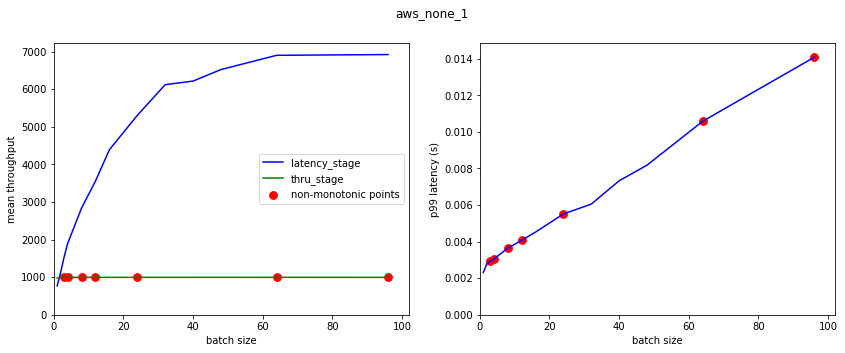

# alexnet

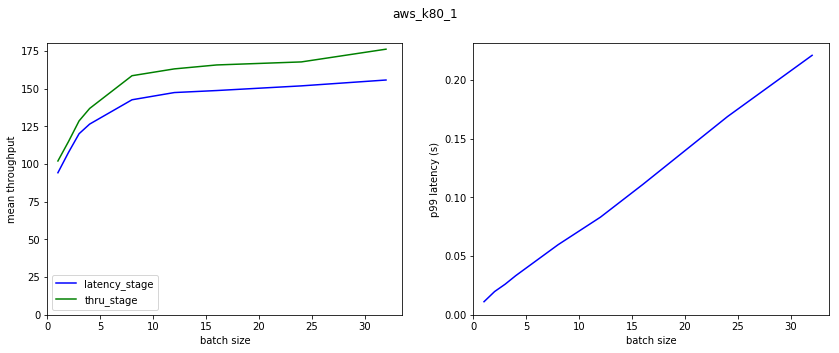

# res152

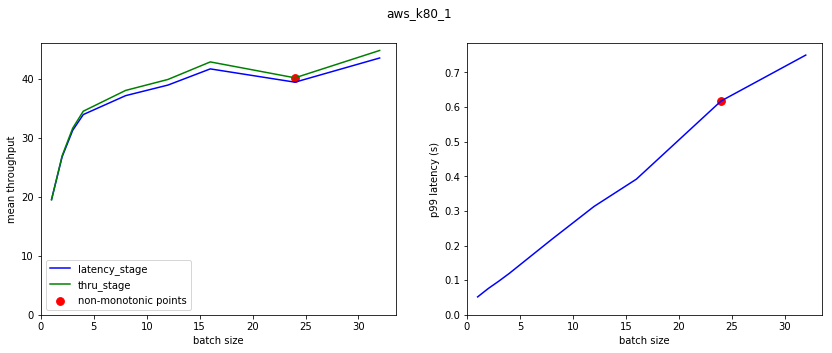

# res50

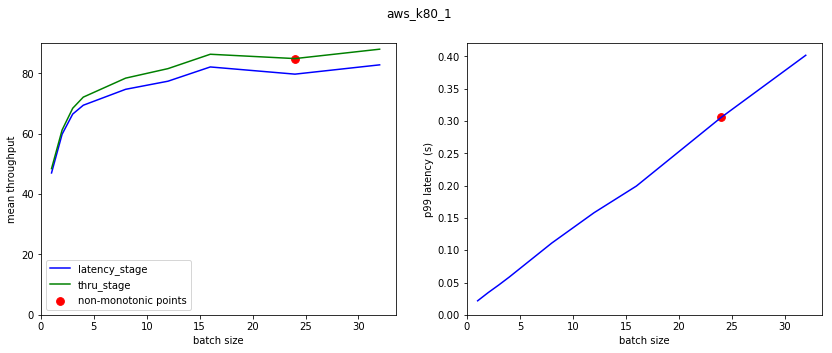

# tf-resnet-feats

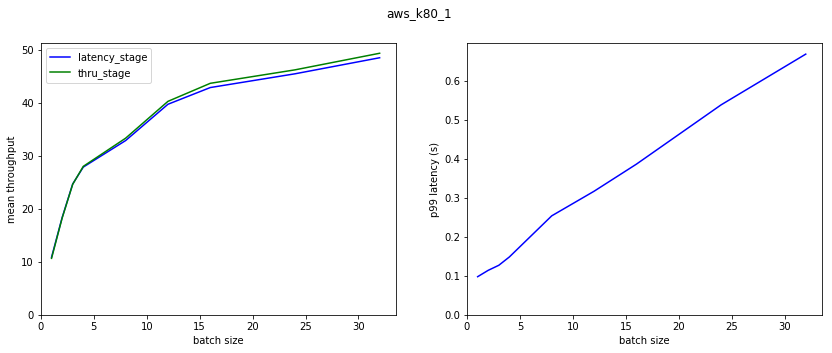

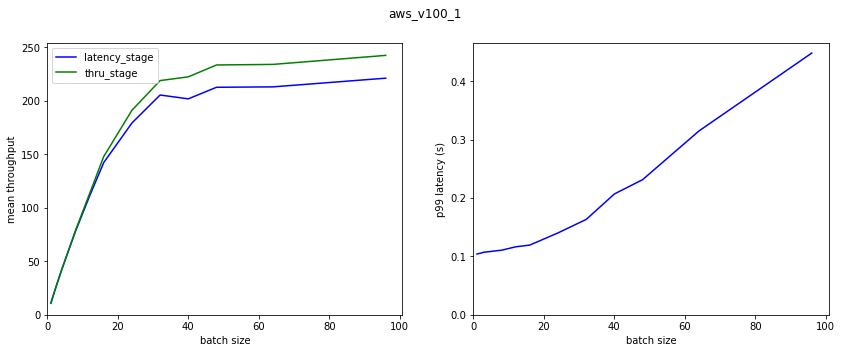

# tf-kernel-svm

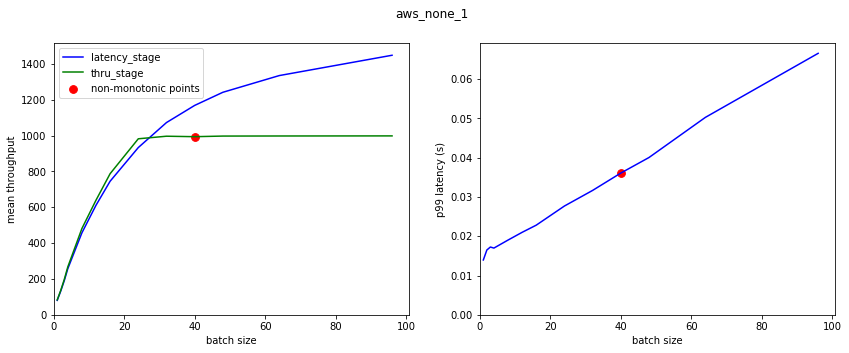

# inception

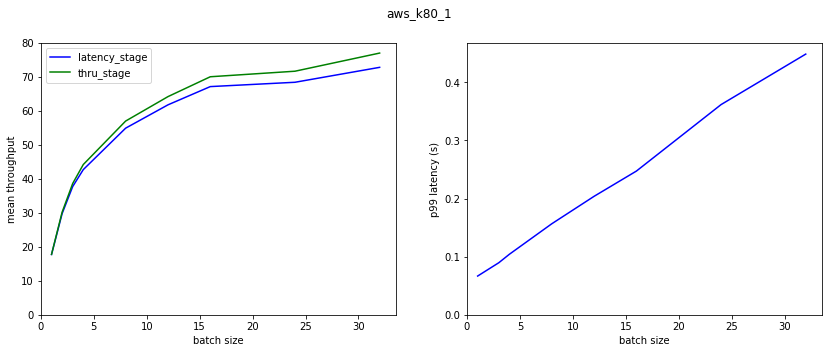

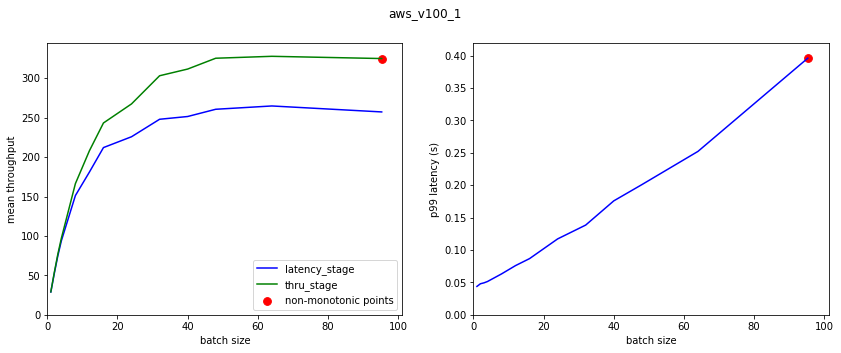

In [19]:
for name, prof in node_profs.items():
    display(Markdown("# {}".format(name)))
    prof.plot_profile()